# HMM Training

This notebook trains the Hidden Markov Model on the corpus.txt file.

## Architecture Decision

We use a position-aware character sequence model that combines:
1. Position-specific character frequencies
2. Character bigram probabilities (character transitions)
3. Character trigram probabilities
4. Global character frequencies

This approach captures both positional patterns (e.g., 'E' is common at position 0, 'S' at the end) and sequential patterns (e.g., 'TH', 'QU' are common pairs).


In [1]:
import sys
import os
sys.path.append('../src')

import numpy as np
import pickle
import matplotlib.pyplot as plt
from hmm_model import HangmanHMM

# Load preprocessed data
with open('../results/preprocessed_data.pkl', 'rb') as f:
    preprocessed_data = pickle.load(f)

words = preprocessed_data['words']
print(f"Loaded {len(words)} words for training")
print(f"Sample words: {words[:5]}")


Loaded 50000 words for training
Sample words: ['suburbanize', 'asmack', 'hypotypic', 'promoderationist', 'consonantly']


In [2]:
# Initialize HMM model
# Use max_word_length based on corpus analysis
max_word_length = max(preprocessed_data['word_lengths'])
print(f"Maximum word length in corpus: {max_word_length}")

hmm = HangmanHMM(max_word_length=max_word_length)


Maximum word length in corpus: 24


In [3]:
# Train the HMM model
hmm.train(words)


Training HMM on 50000 words...
Training complete. Processed 50000 words.
Word length range: 1 - 24


In [4]:
# Analyze trained model statistics
print("=" * 60)
print("HMM MODEL STATISTICS")
print("=" * 60)
print(f"Total words trained: {hmm.total_words}")
print(f"Word length range: {min(hmm.length_counts.keys())} - {max(hmm.length_counts.keys())}")
print(f"\nTop 10 most common word lengths:")
for length, count in hmm.length_counts.most_common(10):
    print(f"  Length {length}: {count} words ({count/hmm.total_words*100:.2f}%)")

print(f"\nGlobal character frequencies (top 10):")
for char, count in hmm.global_char_counts.most_common(10):
    print(f"  {char}: {count} occurrences ({count/sum(hmm.global_char_counts.values())*100:.2f}%)")

print(f"\nPosition-specific statistics:")
for pos in range(min(10, hmm.max_word_length)):
    pos_counts = hmm.position_char_counts[pos]
    if pos_counts:
        top_char = pos_counts.most_common(1)[0]
        print(f"  Position {pos}: Most common = '{top_char[0]}' ({top_char[1]} occurrences)")
print("=" * 60)


HMM MODEL STATISTICS
Total words trained: 50000
Word length range: 1 - 24

Top 10 most common word lengths:
  Length 9: 6787 words (13.57%)
  Length 10: 6465 words (12.93%)
  Length 8: 6369 words (12.74%)
  Length 11: 5452 words (10.90%)
  Length 7: 5111 words (10.22%)
  Length 12: 4292 words (8.58%)
  Length 6: 3755 words (7.51%)
  Length 13: 3094 words (6.19%)
  Length 5: 2340 words (4.68%)
  Length 14: 2019 words (4.04%)

Global character frequencies (top 10):
  e: 49224 occurrences (10.37%)
  a: 42110 occurrences (8.87%)
  i: 42068 occurrences (8.86%)
  o: 35829 occurrences (7.55%)
  r: 33619 occurrences (7.08%)
  n: 33314 occurrences (7.02%)
  t: 32191 occurrences (6.78%)
  s: 29044 occurrences (6.12%)
  l: 27406 occurrences (5.77%)
  c: 21718 occurrences (4.57%)

Position-specific statistics:
  Position 0: Most common = 'p' (5198 occurrences)
  Position 1: Most common = 'e' (7007 occurrences)
  Position 2: Most common = 'r' (4871 occurrences)
  Position 3: Most common = 'e' (5368

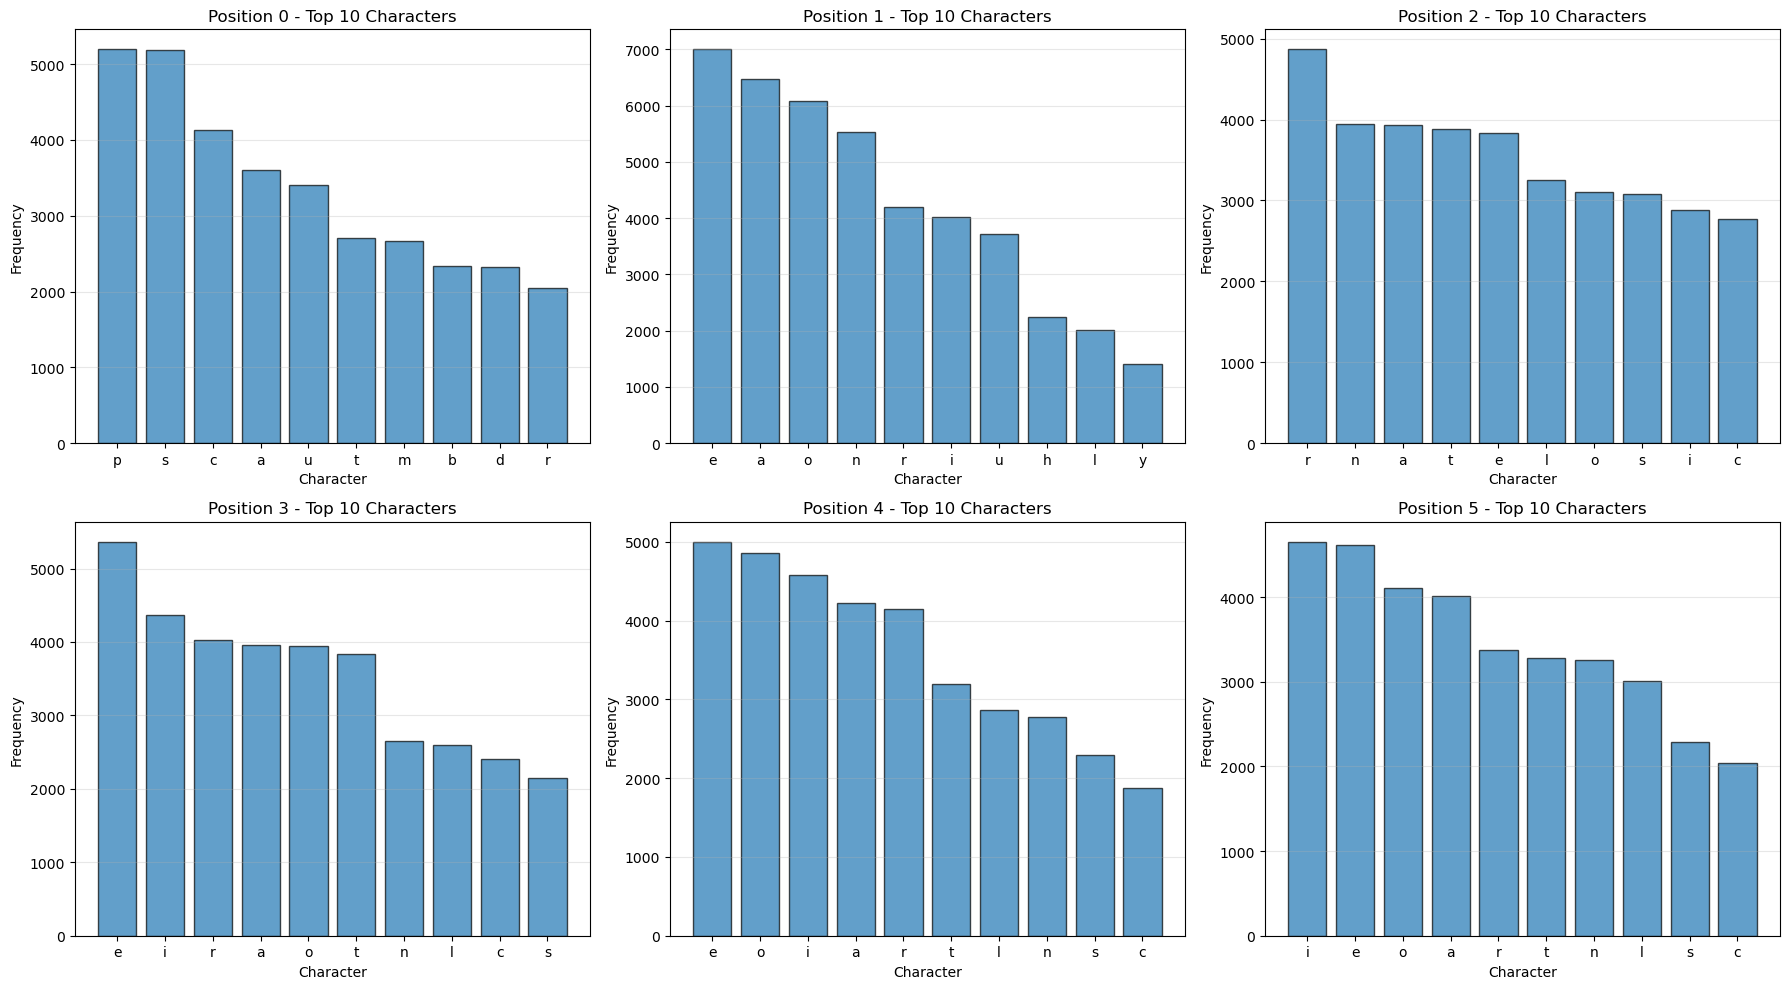

In [5]:
# Visualize position-specific character frequencies for first few positions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for pos in range(min(6, hmm.max_word_length)):
    pos_counts = hmm.position_char_counts[pos]
    if pos_counts:
        chars = [char for char, _ in pos_counts.most_common(10)]
        counts = [count for _, count in pos_counts.most_common(10)]
        axes[pos].bar(chars, counts, edgecolor='black', alpha=0.7)
        axes[pos].set_title(f'Position {pos} - Top 10 Characters')
        axes[pos].set_xlabel('Character')
        axes[pos].set_ylabel('Frequency')
        axes[pos].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/hmm_position_frequencies.png', dpi=150, bbox_inches='tight')
plt.show()


In [6]:
# Save the trained model
os.makedirs('../models', exist_ok=True)
model_path = '../models/hmm_model.pkl'
hmm.save(model_path)
print(f"\n✓ Model saved successfully to {model_path}")


Model saved to ../models/hmm_model.pkl

✓ Model saved successfully to ../models/hmm_model.pkl


In [8]:
# Test the model with a simple example
print("Testing HMM inference on example word 'example':")
test_word = "example"
masked = ['_'] * len(test_word)
guessed = set()

print(f"Initial state: {''.join(masked)}")
probs = hmm.predict_letter_probabilities(masked, guessed, len(test_word))
top_5 = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:5]
print(f"Top 5 predicted letters: {top_5}")

# Reveal one letter
masked[0] = 'e'
guessed.add('e')
print(f"\nAfter guessing 'e': {''.join(masked)}")
probs = hmm.predict_letter_probabilities(masked, guessed, len(test_word))
top_5 = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:5]
print(f"Top 5 predicted letters: {top_5}")


Testing HMM inference on example word 'example':
Initial state: _______
Top 5 predicted letters: [('e', 0.10366177251017158), ('a', 0.0886802624817838), ('i', 0.088591813870427), ('o', 0.0754529832453059), ('r', 0.07079890155248372)]

After guessing 'e': e______
Top 5 predicted letters: [('a', 0.09893616021502345), ('i', 0.09883748249645231), ('o', 0.08417914234965744), ('r', 0.0789868147772233), ('n', 0.0782702265828376)]
